<a href="https://colab.research.google.com/github/ZackAkil/machine-learning-trenches-and-highways/blob/master/Machine_Learning_Trenches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning

Thie notebook will walk you trough the process of building a ML model for predicting **something**.

First we will import our data

---
**Practicle note ⚡**: becuase we are importing data direct from Cloud Storage into Colab, the data never touches our local computer and is leveraging the super fast  download speeds between Google services.

Download the data using the following command:

```bash
!gsutil cp "gs://raw-data-sets/x-ray-pneumonia/training x-ray data.zip" .
```

In [1]:
# [TASK] downlaod data using gsutil 

!gsutil cp "gs://raw-data-sets/x-ray-pneumonia/training x-ray data.zip" .

Copying gs://raw-data-sets/x-ray-pneumonia/training x-ray data.zip...
| [1 files][  1.2 GiB/  1.2 GiB]   67.2 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


Now that the zip file of our data in donwloaded, we can unzip it using:
```bash

!unzip -q "training x-ray data.zip"
```

In [0]:
# [TASK] unzip the data

!unzip -q "training x-ray data.zip"

## Go OOM or go home🎈
(OOM means "Out of memory")

Machine learning models love having lots of data to learn from, unfortunatly (and especially in image based models) all that data can quickly fill up the memory of our environments causing explicit OOM (Out of Memory) errors if we are lucky, and more obscure errors when we are not so lucky. 

There are a couple of ways to work through this problem:

-

**A.**  Brute force it 

---
You can run the code on a local machine that has more memory, **or** set up and configure your own remote VM with more memory, **or** use a cloud hosted managed notebook service like [AI Platform Noetbooks](https://cloud.google.com/ai-platform-notebooks/) that allows you to easily customise the harware of a remote notebook environment.

-

**B.** Just use less data

---
Usually the quickest solution is to just using a sample of your data that fits in memory, however this isn't ideal if you need the best possible model, it is good if you're just experimenting around with POCs (proof of concepts).

-

**C.** Compress your data (mostly for images)

---
You don't normally need high resolution images of cats to detect if there is a cat, so it's common to see machine learning models trained on what we would see as "low resolution" images e.g 128x128 pixels or even in the case of the famous [MNIST dataset ](https://en.wikipedia.org/wiki/MNIST_database): 28x28 pixels.


Example 4mb image of cat

<img src="https://storage.googleapis.com/random-assets/images/cat_bed_4mb.jpg" height=200></img>

Example 70kb image of cat

<img src="https://storage.googleapis.com/random-assets/images/cat_bed_80kb.png" height=200></img>

In both images you can clearly see that there is a cat, therefore a machine learning model could learn that there is a cat from both, except for the same memory used in the first (4mb) image you could load in more than 50 (70kb) images  and expect to get the same performance from your model.

### Now lets look at some of our data:

In [4]:
# import package that lets use navigate files
import os

# get list of file names in the NORMAL folder
folder_name = "NORMAL/"
file_name_list = os.listdir(folder_name)

# what is the first file name of NORMAL images
print(folder_name + file_name_list[0])

NORMAL/IM-0727-0001.jpeg


In [0]:
# import package that lets us load in an image
import skimage.io as io

# load image
image = io.imread(folder_name + file_name_list[0])

Let's just print out the image using the `print()` function, what do you expect to see?

In [6]:
# [TASK] print out the image you just loaded in

print(image)

[[ 0 30 26 ... 80 81 81]
 [ 0 31 28 ... 87 85 81]
 [ 0 31 28 ... 82 80 81]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


You can see the dimensions (resolution) of the image by looking at the `.shape` property of the image like so:

```python
print(my_image.shape)
```

In [7]:
# [TASK] check the dimensions of your image

image.shape

(1190, 1400)

Let's actually see the image, there is very popular data visualisation package called [`matplotlib`](https://matplotlib.org/) that we can use for that. Use the following code to display the image:
```python
plt.imshow(my_image)
```



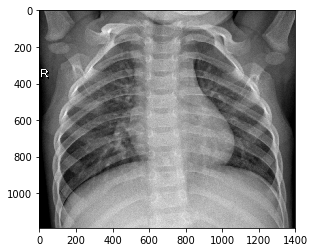

In [8]:
# import package that lets us plot charts and graphics
import matplotlib.pyplot as plt

# [TASK] display the image
plt.imshow(image, cmap='gray')

## Let's import a lot of data now
When dealing with real data it's unlikly to ever be in exactly the right format. This lesson is no different! 

Our data is stored across multiple folders in diferent types of images (**grayscale** and **<font color='red'>R</font><font color='green'>G</font><font color='blue'>B</font>**) and even different resolutions. A Machine Leanring model **can not** handle different types of images without preprocessing.

To save everyone alot of headache below is a function that will do the preprocessing on this data for us. Specifically it will

1.   Import each image as a matrix
2.   Convert RGB images to grayscale
3.   Resize all images to be the same resolution

[**TASK**] Read through and run the code to create the function `load_images_from_folder`

In [0]:
# import package that lets you resize images
import cv2

# import package that will let us combine all the images into one big matrix
import numpy as np

# create function for preprocessing the images
def load_images_from_folder(path, max_to_import=1000, image_resize_shape=(200, 200)):
  
  print('Started import...')
  
  image_list = []    
  image_count = 0
  
  for img_file_name in os.listdir(path):
    
      # skip non-images       
      if img_file_name[-4:] != 'jpeg':
        continue
      
      # import image into matrix format
      image = io.imread(os.path.join(path, img_file_name))

      image_count +=1
      
      # annoyingly some of the images are RGB and and have a shape like [480, 640, 3]    
      # whilst most others are grayscale and have a shape like [480, 640]. So let's convert
      # the multi-channel RGB images to single channel images.       
      if len(image.shape) > 2:
        image = image[:,:,0]

      # resize image and add it to the list of images
      image_list.append(cv2.resize(image, dsize=image_resize_shape)) 

      # every 200 images print out a message so that we know it's doing something      
      if (image_count%200)==0:
        print('imported ', image_count)

      # quit function when reached max_to_import          
      if image_count >= max_to_import:
        break
        
  return np.stack(image_list)

Lets use the created function 

BUT you need to make a choice of how much data to import  and what size to set all of the images to:

FYI: there is 1500 NORMAL images and  4000 PNEUMONIA images, and you could use image shapes of (24, 24) all the way to (2000, 2000). 

**You're likely going to be experimenting with these values.**

In [12]:
# [TASK] Pick a max_to_import number and image_resize_shape (replace the 1's)
image_resize_shape = (1, 1)

normal = load_images_from_folder('NORMAL/', 
                                 max_to_import=1, 
                                 image_resize_shape = image_resize_shape)
pneumonia = load_images_from_folder('PNEUMONIA/', 
                                    max_to_import = 1, 
                                    image_resize_shape = image_resize_shape)

Started import...
imported  200
imported  400
imported  600
imported  800
imported  1000
Started import...
imported  200
imported  400
imported  600
imported  800
imported  1000


## Building the training dataset 🏫

We now need to organise our data so that we have the "**input**" data to our model (the image of an X-ray) along side the correct answers (the "**output**" data). In our case we want our model to output "**0**" went it's a "**normal**" X-ray, and "**1**" when it's and X-ray of "**pnemonia**". 

It's machine learning convention to assign the input data to a varible **`X`** and the output data to a varible **`y`**.


## Some weird data structuring
We are going to convert our data from an image shape (e.g [400, 400] ) to a single array of values (e.g [160000]). THis is so that we call feed it into our neural network later. 

We'll come back to this stage later 😉

In [14]:
# import package to convert our outputs into the correct format
import keras

# join together the normal and pneumonia data 
X = np.concatenate([normal, pneumonia])
y = np.concatenate([np.zeros(len(normal)), np.ones(len(pneumonia))])

# change the shape of the image data to be a long line of pixels for the first neural network 
X = X.reshape(2000, image_resize_shape[0]*image_resize_shape[1] ) / 255.

# # [FUTURE TASK] replace the previous line with the following line
# the following line is for when your using the next neural network type 
# X = X.reshape(2000, image_resize_shape[0], image_resize_shape[1], 1)/255.

# convert the labels into the correct format for the neural network
y = keras.utils.to_categorical(y, 2)

Using TensorFlow backend.


## Train/Test split our data
There is no point testing a student with the exact same question you asked them in a class exersice, they could have just memorised the answers. Machien learning models are no different. That is why it's important to split our data in a **training** set that it tries to learn from, and a **test** set that we use to check the models accuracy with.

  [Sci-Kit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) is popular open-source machine learning library with a lot of tools for building models and data proprosessing, including and handy function that will train/test **and** shuffle our data for us. It's import to also shuffle our data as you want an even distribution of 'normal' and 'pnemonia' cases in both the training and test data. 

In [0]:
# import package that will do teh train/test split and shuffle of our data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

## Time to build a model 🤖
We are going to use a machaine learning package called [Keras](https://keras.io/) that is a populare opensource package used in deeplearning.

In [0]:
# import packages for building a neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

## Building our network
The only thing that is defininate is the input shape layer (it has to match the input data we are using) and the output shape layer (it has to match the output data we are using), all of the inbetween layers are up for experimenting with. 

**feel free to add and remove the middle layers to see what works best**

In [18]:
# create our neural network layer by layer

model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(image_resize_shape[0]*image_resize_shape[1],)))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax'))


## [FUTURE TASK] replace all of teh previous code with the following 
## code to create a neural network that is better for images

# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=(image_resize_shape[0], image_resize_shape[1], 1)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(2, activation='softmax'))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# compile model to set the optimisation algorithm and metrics we want to see during training

model.compile(loss='categorical_crossentropy',
              optimizer='Adadelta',
              metrics=['accuracy'])

In [20]:
# train the model for 3 epoch with our training data and test using our test data 

model.fit(X_train, y_train, 
          epochs=3,
          validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 1340 samples, validate on 660 samples
Epoch 1/3
1340/1340 [==============================] - 16s 12ms/step - loss: 1.1474 - acc: 0.6224 - val_loss: 0.5823 - val_acc: 0.6530
Epoch 2/3
1340/1340 [==============================] - 7s 5ms/step - loss: 0.4549 - acc: 0.8164 - val_loss: 0.3245 - val_acc: 0.8848
Epoch 3/3
1340/1340 [==============================] - 7s 5ms/step - loss: 0.2566 - acc: 0.9037 - val_loss: 0.2117 - val_acc: 0.9076


## If this is your first time with the first neural networ structure:
It probebly doesn't look very good. Why don't you change:


*   The amont and resize shape of the data
Then try
*   The second network structure (make sure you change the data stucture to fit into the second network, back in the "**Some weird data structuring** part of the notebook)



## Let's go faster 🚀

Now that we are training a model, we might want it to train faster (your time is the most valuble resource). So let's swtch our runtion to one with a GPU.   

In Colab the tool bar navigate to: **`Runtime > Change runtime type`**, then select **`GPU`** from the **`Hardware Accelerator`** dropdown.

You'll have to re-run all of your code now becuase the environment has to restart to attach the GPU.

---
**Practicle note⚡** : before running long training jobs, it's good to double check that the GPU is definitely being detected by our ML libraries using the following code:
```python
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
```

## Now Re-run the notebook now that you have a GPU enabled environment!

# Lets use our model to make predictions ⚕️
We can call the `.predict` function on our model to send it predictions. Let's look what the raw prediction output looks like from the model: 

In [22]:
# make a prediction on the first 5 test images
predictions = model.predict(X_test[:5])
predictions

array([[0.00421774, 0.99578226],
       [0.935539  , 0.06446094],
       [0.6668215 , 0.33317855],
       [0.9871644 , 0.01283562],
       [0.01658188, 0.98341817]], dtype=float32)

Let's display the predictions along side the the true values and the input data (the X-ray image).

predicted: pneumonia
truth: pneumonia


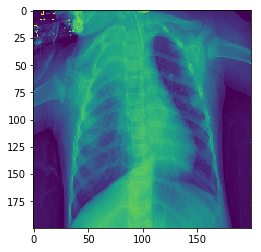

predicted: normal
truth: normal


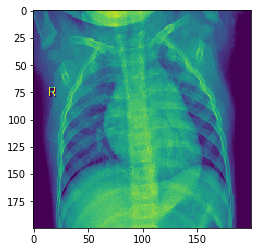

predicted: normal
truth: pneumonia


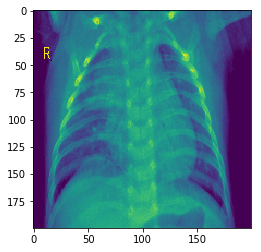

predicted: normal
truth: normal


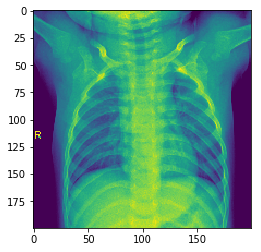

predicted: pneumonia
truth: pneumonia


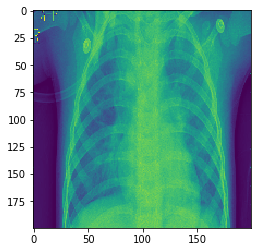

In [39]:
for pred, truth, img in zip(predictions, y_test[:5], X_test[:5]):
  
  # predict pneumonia when the pneumonia class is over 0.5    
  if pred[1] > 0.5:
    print('predicted: pneumonia')
  else:
    print('predicted: normal')
  
  # show the true value of the image   
  if truth[1]:
    print('truth: pneumonia')
  else:
    print('truth: normal')
  
  # show the image  
  plt.imshow(img[:,:,0])
  plt.show()  

# Done 🏁

Hopfully you now have more awareness of the process of building deep neural network models with images and GPU acceleration.